In [ ]:
# Samuel Göbel
# Master Thesis Data Science and Society
# Tilburg University

# Burnout Prediction Among Medical Students


# Experiment 3: Model Perfromance SMOTE-Borderline oversampling


In [ ]:
# ------------------------------------------------------------------------------
# Overview Experiment 3:
# ------------------------------------------------------------------------------



# Target variable ‘burnout’, excluding any mbi-related variables

# Models to compare: logistic regression, dt, rf, svm, xgb and tabnet

# Stratified 80/20 train/test split

# model training via 5 fold cross validation, applying SMOTE-Borderline to the training
# folds, not the validation folds.

# randomized hyperparameter tuning via 5 fold cross validation,
# applying SMOTE-Borderline to the training folds, not the validation folds.

# Train model with best hyperparameters on the entire training set with SMOTE-Borderline applied




In [ ]:
# required fot SMOTE Borderline
! pip install imbalanced-learn

#TabNet
!pip install pytorch-tabnet

# Optuna
!pip install optuna

In [ ]:
# Standard libraries
import random

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Model selection
from sklearn.model_selection import (
    RandomizedSearchCV,
    StratifiedKFold,
    train_test_split
)

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Evaluation metrics
from sklearn.metrics import (
    average_precision_score,
    classification_report,
    cohen_kappa_score,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve
)

# Imbalanced learning
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline

# Deep learning and optimization
import optuna
import torch
from pytorch_tabnet.tab_model import TabNetClassifier


In [ ]:
# using the precprocessed clean data
data = pd.read_csv("/content/drive/MyDrive/Master Thesis 2025/BurnoutDataset/data_encoded_clean.csv")



In [ ]:
# Specifying target and predictors ------------------------------
# Stratified train test split



# Drop MBI-related columns
mbi_columns = ['mbi_ex', 'mbi_cy', 'mbi_ea', 'mbi_total', 'mbi_ea_rev']
df_filtered = data.drop(columns=mbi_columns)



# Define features and target
X = df_filtered.drop(columns=['burnout'])
y = df_filtered['burnout']



# Perform stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_test.shape, y_train.value_counts(), y_test.value_counts()


((708, 23),
 (178, 23),
 burnout
 0    680
 1     28
 Name: count, dtype: int64,
 burnout
 0    171
 1      7
 Name: count, dtype: int64)

In [ ]:
# ------------------------------------------------------------------------------
# Logistic Regression with Borderline-SMOTE
# ------------------------------------------------------------------------------



# pipeline
pipeline = Pipeline([
    ('smote', BorderlineSMOTE(random_state=42)),
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])



# hyperparameter search space
param_dist = {
    'logreg__C': np.logspace(-4, 4, 20),
    'logreg__penalty': ['l1', 'l2'],
    'logreg__solver': ['liblinear']  # required for l1
}




# 5-fold stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)




# hyperparameter tuning with RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1',
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)




# fit the model (tuning + training inside CV folds)
search.fit(X_train, y_train)




# retrieve best parameters
best_params = search.best_params_
print("Best hyperparameters:", best_params)





# Step 7: Retrain model on full training data with Borderline-SMOTE
smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

final_model = LogisticRegression(
    C=best_params['logreg__C'],
    penalty=best_params['logreg__penalty'],
    solver=best_params['logreg__solver'],
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)
final_model.fit(X_train_resampled, y_train_resampled)






# Evaluate on TRAINING set
y_train_pred = final_model.predict(X_train_resampled)
y_train_proba = final_model.predict_proba(X_train_resampled)[:, 1]

print("\nTraining Performance:")
print(f"Precision: {precision_score(y_train_resampled, y_train_pred):.4f}")
print(f"Recall: {recall_score(y_train_resampled, y_train_pred):.4f}")
print(f"F1 Score: {f1_score(y_train_resampled, y_train_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_train_resampled, y_train_proba):.4f}")
print(f"Cohen’s Kappa: {cohen_kappa_score(y_train_resampled, y_train_pred):.4f}")






# Evaluate on TEST set
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
cohen_kappa = cohen_kappa_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\nTest Performance:")
print(classification_report(y_test, y_pred))
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Cohen’s Kappa: {cohen_kappa:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparameters: {'logreg__solver': 'liblinear', 'logreg__penalty': 'l1', 'logreg__C': 0.03359818286283781}

Training Performance:
Precision: 0.8423
Recall: 0.9426
F1 Score: 0.8897
ROC AUC: 0.9457
Cohen’s Kappa: 0.7662

Test Performance:
              precision    recall  f1-score   support

           0       0.98      0.76      0.86       171
           1       0.11      0.71      0.19         7

    accuracy                           0.76       178
   macro avg       0.55      0.74      0.52       178
weighted avg       0.95      0.76      0.83       178

Precision: 0.1087
Recall: 0.7143
F1 Score: 0.1887
ROC AUC: 0.8780
Cohen’s Kappa: 0.1292

Confusion Matrix:
 [[130  41]
 [  2   5]]


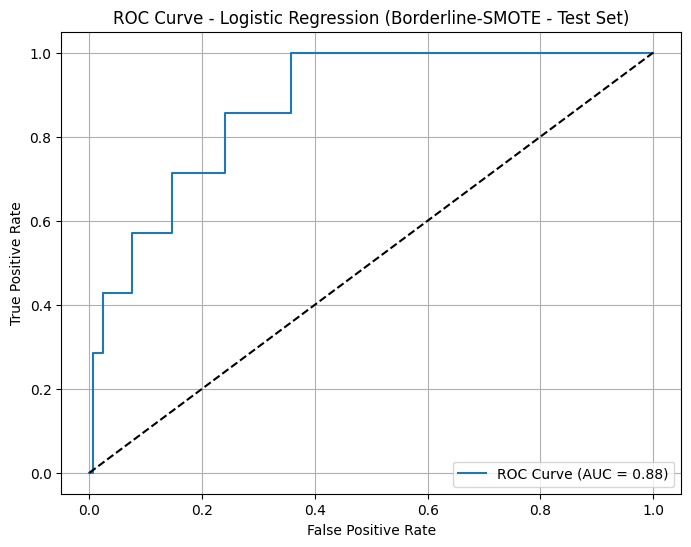

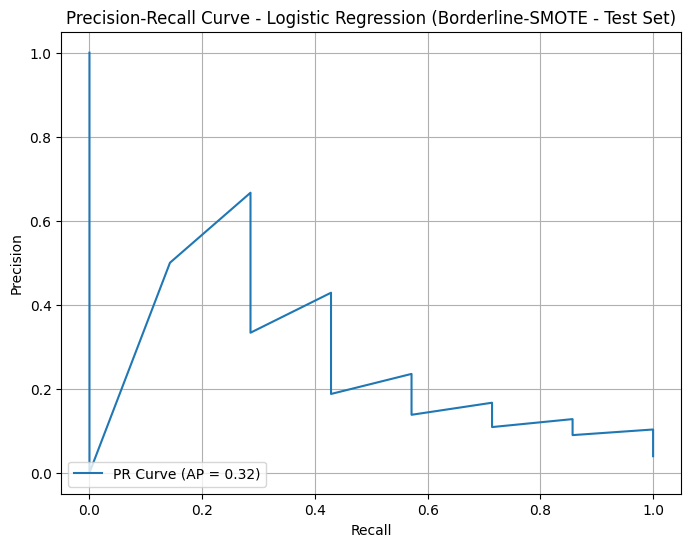

In [ ]:
# -----------------------------------------------
# ROC-AUC Visualization Log Reg






# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression (Borderline-SMOTE - Test Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()






# -----------------------------------------------
# Precision-Recall (PR) Curve Visualization


# Compute Precision-Recall curve
precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_test, y_proba)

# Compute Average Precision (AP) score
ap_score = average_precision_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, label=f'PR Curve (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Logistic Regression (Borderline-SMOTE - Test Set)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


# Decision Tree

In [ ]:
# ------------------------------------------------------------------------------
# Decision Tree with Borderline-SMOTE
# ------------------------------------------------------------------------------





# pipeline
dt_pipeline = Pipeline([
    ('smote', BorderlineSMOTE(random_state=42)),
    ('dt', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])






# hyperparameter search space
dt_param_dist = {
    'dt__max_depth': [None, 5, 10, 20, 30],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4],
    'dt__criterion': ['gini', 'entropy']
}






# rRandomizedSearchCV with Stratified 5-Fold CV
dt_search = RandomizedSearchCV(
    estimator=dt_pipeline,
    param_distributions=dt_param_dist,
    n_iter=30,
    scoring='f1',
    cv=cv,  # same StratifiedKFold from earlier
    verbose=1,
    random_state=42,
    n_jobs=-1
)






# fit the model (tuning + training inside folds)
dt_search.fit(X_train, y_train)





# best parameters
best_dt_params = dt_search.best_params_
print("Best hyperparameters:", best_dt_params)





# retrain model on full training data with Borderline-SMOTE
smote = BorderlineSMOTE(random_state=42)
X_train_resampled_dt, y_train_resampled_dt = smote.fit_resample(X_train, y_train)

final_dt = DecisionTreeClassifier(
    max_depth=best_dt_params['dt__max_depth'],
    min_samples_split=best_dt_params['dt__min_samples_split'],
    min_samples_leaf=best_dt_params['dt__min_samples_leaf'],
    criterion=best_dt_params['dt__criterion'],
    class_weight='balanced',
    random_state=42
)
final_dt.fit(X_train_resampled_dt, y_train_resampled_dt)







# Evaluate on TRAINING set
y_train_pred_dt = final_dt.predict(X_train_resampled_dt)
y_train_proba_dt = final_dt.predict_proba(X_train_resampled_dt)[:, 1]

print("\nTraining Performance:")
print(f"Precision: {precision_score(y_train_resampled_dt, y_train_pred_dt):.4f}")
print(f"Recall: {recall_score(y_train_resampled_dt, y_train_pred_dt):.4f}")
print(f"F1 Score: {f1_score(y_train_resampled_dt, y_train_pred_dt):.4f}")
print(f"ROC AUC: {roc_auc_score(y_train_resampled_dt, y_train_proba_dt):.4f}")
print(f"Cohen’s Kappa: {cohen_kappa_score(y_train_resampled_dt, y_train_pred_dt):.4f}")







# Evaluate on TEST set
y_pred_dt = final_dt.predict(X_test)
y_proba_dt = final_dt.predict_proba(X_test)[:, 1]

precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
roc_auc_dt = roc_auc_score(y_test, y_proba_dt)
cohen_kappa_dt = cohen_kappa_score(y_test, y_pred_dt)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)

print("\nTest Performance:")
print(classification_report(y_test, y_pred_dt))
print(f"Precision: {precision_dt:.4f}")
print(f"Recall: {recall_dt:.4f}")
print(f"F1 Score: {f1_dt:.4f}")
print(f"ROC AUC: {roc_auc_dt:.4f}")
print(f"Cohen’s Kappa: {cohen_kappa_dt:.4f}")
print("\nConfusion Matrix:\n", conf_matrix_dt)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparameters: {'dt__min_samples_split': 10, 'dt__min_samples_leaf': 1, 'dt__max_depth': 5, 'dt__criterion': 'entropy'}

Training Performance:
Precision: 0.9437
Recall: 0.9618
F1 Score: 0.9527
ROC AUC: 0.9832
Cohen’s Kappa: 0.9044

Test Performance:
              precision    recall  f1-score   support

           0       0.96      0.89      0.93       171
           1       0.05      0.14      0.08         7

    accuracy                           0.87       178
   macro avg       0.51      0.52      0.50       178
weighted avg       0.93      0.87      0.89       178

Precision: 0.0526
Recall: 0.1429
F1 Score: 0.0769
ROC AUC: 0.5898
Cohen’s Kappa: 0.0206

Confusion Matrix:
 [[153  18]
 [  6   1]]


ROC AUC: 0.5898


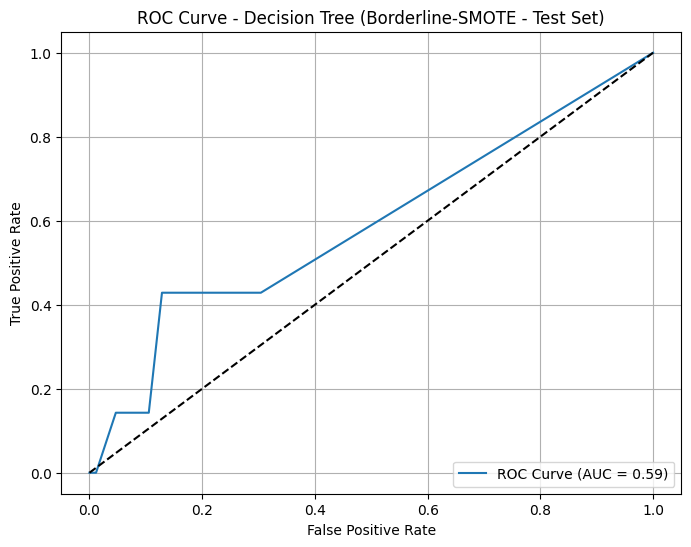

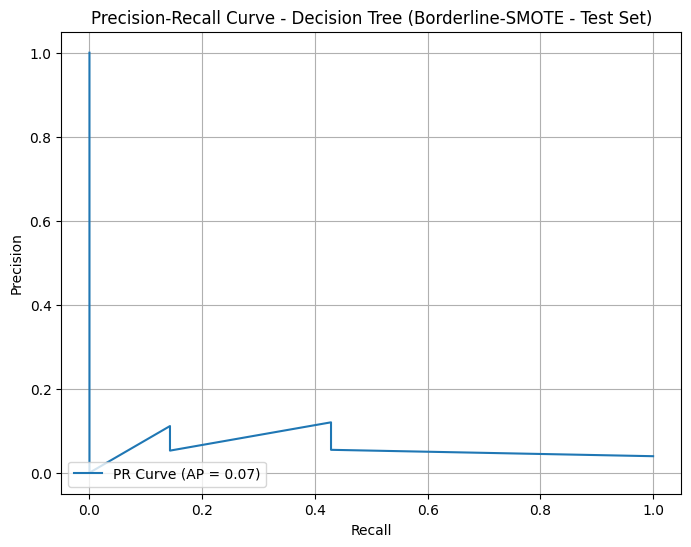

In [ ]:
# ------------------------------------------------------
# ROC-AUC Curve Decision Tree





# Calculate False Positive Rate, True Positive Rate
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_proba_dt)
roc_auc_dt = roc_auc_score(y_test, y_proba_dt)
print(f"ROC AUC: {roc_auc_dt:.4f}")


# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, label=f'ROC Curve (AUC = {roc_auc_dt:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree (Borderline-SMOTE - Test Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()







# ------------------------------------------------------
# Precision-Recall (PR) Curve Decision Tree


# Calculate Precision-Recall
precision_vals_dt, recall_vals_dt, thresholds_pr_dt = precision_recall_curve(y_test, y_proba_dt)
ap_score_dt = average_precision_score(y_test, y_proba_dt)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall_vals_dt, precision_vals_dt, label=f'PR Curve (AP = {ap_score_dt:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Decision Tree (Borderline-SMOTE - Test Set)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


# Random Forest

In [ ]:
# ------------------------------------------------------------------------------
# Random Forest with Borderline-SMOTE
# ------------------------------------------------------------------------------


# pipeline
rf_pipeline = Pipeline([
    ('smote', BorderlineSMOTE(random_state=42)),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))
])







# hyperparameter search space
rf_param_dist = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__bootstrap': [True, False]
}





# randomizedSearchCV with Stratified 5-Fold CV
rf_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_param_dist,
    n_iter=30,
    scoring='f1',
    cv=cv,  # same StratifiedKFold
    verbose=1,
    random_state=42,
    n_jobs=-1
)





# fit the model (tuning + training inside folds)
rf_search.fit(X_train, y_train)





# best parameters
best_rf_params = rf_search.best_params_
print("Best hyperparameters:", best_rf_params)





# retrain model on full training data with BorderlineSMOTE
smote = BorderlineSMOTE(random_state=42)
X_train_resampled_rf, y_train_resampled_rf = smote.fit_resample(X_train, y_train)

final_rf = RandomForestClassifier(
    n_estimators=best_rf_params['rf__n_estimators'],
    max_depth=best_rf_params['rf__max_depth'],
    min_samples_split=best_rf_params['rf__min_samples_split'],
    min_samples_leaf=best_rf_params['rf__min_samples_leaf'],
    bootstrap=best_rf_params['rf__bootstrap'],
    class_weight='balanced',
    random_state=42
)

final_rf.fit(X_train_resampled_rf, y_train_resampled_rf)







# Evaluate on TRAINING set
y_train_pred_rf = final_rf.predict(X_train_resampled_rf)
y_train_proba_rf = final_rf.predict_proba(X_train_resampled_rf)[:, 1]

print("\nTraining Performance:")
print(f"Precision: {precision_score(y_train_resampled_rf, y_train_pred_rf):.4f}")
print(f"Recall: {recall_score(y_train_resampled_rf, y_train_pred_rf):.4f}")
print(f"F1 Score: {f1_score(y_train_resampled_rf, y_train_pred_rf):.4f}")
print(f"ROC AUC: {roc_auc_score(y_train_resampled_rf, y_train_proba_rf):.4f}")
print(f"Cohen’s Kappa: {cohen_kappa_score(y_train_resampled_rf, y_train_pred_rf):.4f}")








# Evaluate on TEST set
y_pred_rf = final_rf.predict(X_test)
y_proba_rf = final_rf.predict_proba(X_test)[:, 1]

precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
cohen_kappa_rf = cohen_kappa_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

print("\nTest Performance:")
print(classification_report(y_test, y_pred_rf))
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print(f"ROC AUC: {roc_auc_rf:.4f}")
print(f"Cohen’s Kappa: {cohen_kappa_rf:.4f}")
print("\nConfusion Matrix:\n", conf_matrix_rf)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparameters: {'rf__n_estimators': 200, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 4, 'rf__max_depth': 20, 'rf__bootstrap': True}

Training Performance:
Precision: 0.9970
Recall: 0.9882
F1 Score: 0.9926
ROC AUC: 0.9993
Cohen’s Kappa: 0.9853

Test Performance:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       171
           1       0.29      0.29      0.29         7

    accuracy                           0.94       178
   macro avg       0.63      0.63      0.63       178
weighted avg       0.94      0.94      0.94       178

Precision: 0.2857
Recall: 0.2857
F1 Score: 0.2857
ROC AUC: 0.8981
Cohen’s Kappa: 0.2565

Confusion Matrix:
 [[166   5]
 [  5   2]]


ROC AUC: 0.8981


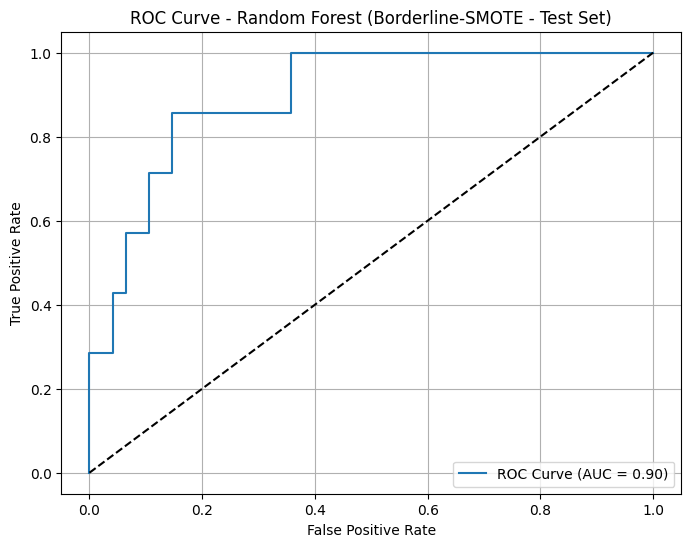

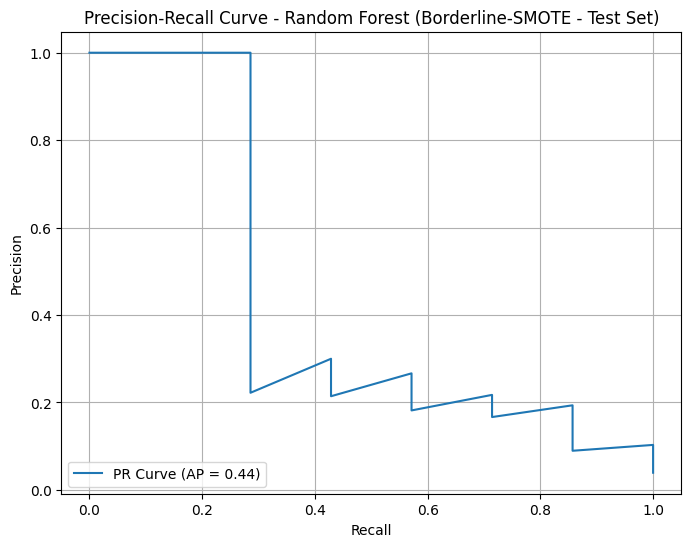

In [ ]:
# ------------------------------------------------------
# ROC-AUC Curve Random Forest



# Calculate FPR, TPR
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_proba_rf)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"ROC AUC: {roc_auc_rf:.4f}")





# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'ROC Curve (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (Borderline-SMOTE - Test Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()






# ------------------------------------------------------
# Precision-Recall (PR) Curve


# Calculate Precision-Recall
precision_vals_rf, recall_vals_rf, thresholds_pr_rf = precision_recall_curve(y_test, y_proba_rf)
ap_score_rf = average_precision_score(y_test, y_proba_rf)



# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall_vals_rf, precision_vals_rf, label=f'PR Curve (AP = {ap_score_rf:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Random Forest (Borderline-SMOTE - Test Set)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


# SVM

In [ ]:
# ------------------------------------------------------------------------------
# Support Vector Machine (SVM) with Borderline-SMOTE
# ------------------------------------------------------------------------------


# pipeline
svm_pipeline = Pipeline([
    ('smote', BorderlineSMOTE(random_state=42)),
    ('svm', SVC(class_weight='balanced', probability=True, random_state=42))
])




# hyperparameter search space
svm_param_dist = {
    'svm__C': np.logspace(-3, 3, 10),
    'svm__gamma': ['scale', 'auto'] + list(np.logspace(-3, 1, 5)),
    'svm__kernel': ['rbf']  # You can add 'linear' or 'poly' if needed
}





# randomizedSearchCV with Stratified 5-Fold CV
svm_search = RandomizedSearchCV(
    estimator=svm_pipeline,
    param_distributions=svm_param_dist,
    n_iter=30,
    scoring='f1',
    cv=cv,  # same StratifiedKFold
    verbose=1,
    random_state=42,
    n_jobs=-1
)





# fit the model (tuning + training inside folds)
svm_search.fit(X_train, y_train)






# best parameters
best_svm_params = svm_search.best_params_
print("Best hyperparameters:", best_svm_params)





# retrain model on full training data with BorderlineSMOTE
smote = BorderlineSMOTE(random_state=42)
X_train_resampled_svm, y_train_resampled_svm = smote.fit_resample(X_train, y_train)

final_svm = SVC(
    C=best_svm_params['svm__C'],
    gamma=best_svm_params['svm__gamma'],
    kernel=best_svm_params['svm__kernel'],
    class_weight='balanced',
    probability=True,
    random_state=42
)

final_svm.fit(X_train_resampled_svm, y_train_resampled_svm)





# Evaluate on TRAINING set
y_train_pred_svm = final_svm.predict(X_train_resampled_svm)
y_train_proba_svm = final_svm.predict_proba(X_train_resampled_svm)[:, 1]

print("\nTraining Performance:")
print(f"Precision: {precision_score(y_train_resampled_svm, y_train_pred_svm):.4f}")
print(f"Recall: {recall_score(y_train_resampled_svm, y_train_pred_svm):.4f}")
print(f"F1 Score: {f1_score(y_train_resampled_svm, y_train_pred_svm):.4f}")
print(f"ROC AUC: {roc_auc_score(y_train_resampled_svm, y_train_proba_svm):.4f}")
print(f"Cohen’s Kappa: {cohen_kappa_score(y_train_resampled_svm, y_train_pred_svm):.4f}")






# Evaluate on TEST set
y_pred_svm = final_svm.predict(X_test)
y_proba_svm = final_svm.predict_proba(X_test)[:, 1]

precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
roc_auc_svm = roc_auc_score(y_test, y_proba_svm)
cohen_kappa_svm = cohen_kappa_score(y_test, y_pred_svm)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

print("\nTest Performance:")
print(classification_report(y_test, y_pred_svm))
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1 Score: {f1_svm:.4f}")
print(f"ROC AUC: {roc_auc_svm:.4f}")
print(f"Cohen’s Kappa: {cohen_kappa_svm:.4f}")
print("\nConfusion Matrix:\n", conf_matrix_svm)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparameters: {'svm__kernel': 'rbf', 'svm__gamma': 0.001, 'svm__C': 0.46415888336127775}

Training Performance:
Precision: 0.8283
Recall: 0.9647
F1 Score: 0.8913
ROC AUC: 0.9512
Cohen’s Kappa: 0.7647

Test Performance:
              precision    recall  f1-score   support

           0       0.98      0.75      0.85       171
           1       0.09      0.57      0.15         7

    accuracy                           0.74       178
   macro avg       0.53      0.66      0.50       178
weighted avg       0.94      0.74      0.82       178

Precision: 0.0851
Recall: 0.5714
F1 Score: 0.1481
ROC AUC: 0.8221
Cohen’s Kappa: 0.0855

Confusion Matrix:
 [[128  43]
 [  3   4]]


ROC AUC: 0.8221


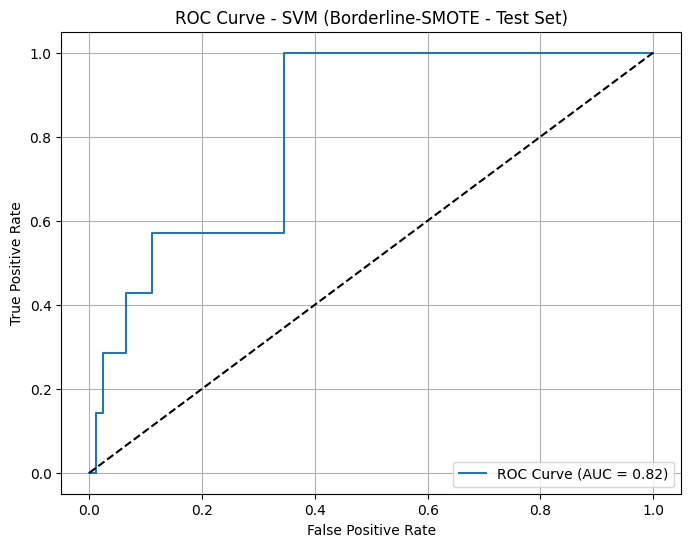

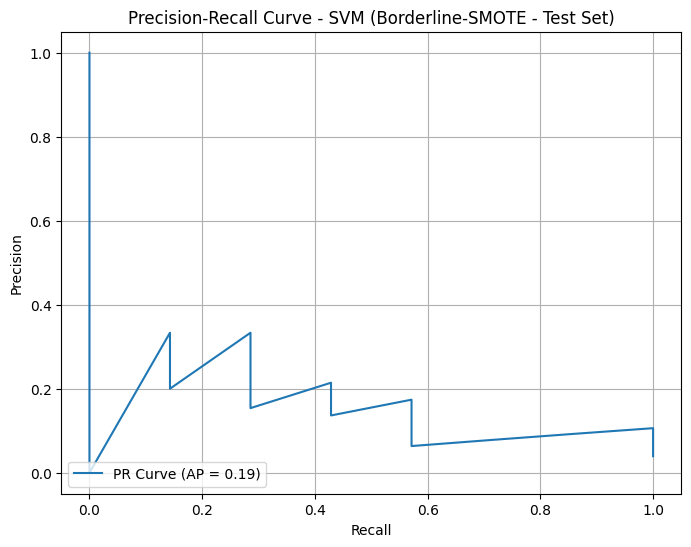

In [ ]:
# ------------------------------------------------------
# ROC-AUC Curve SVM





# Calculate FPR, TPR
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_proba_svm)
roc_auc_svm = roc_auc_score(y_test, y_proba_svm)
print(f"ROC AUC: {roc_auc_svm:.4f}")

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f'ROC Curve (AUC = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM (Borderline-SMOTE - Test Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()





# ------------------------------------------------------
# Precision-Recall (PR) Curve


# Calculate Precision-Recall
precision_vals_svm, recall_vals_svm, thresholds_pr_svm = precision_recall_curve(y_test, y_proba_svm)
ap_score_svm = average_precision_score(y_test, y_proba_svm)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall_vals_svm, precision_vals_svm, label=f'PR Curve (AP = {ap_score_svm:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - SVM (Borderline-SMOTE - Test Set)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


# XGBoost

In [ ]:
# ------------------------------------------------------------------------------
# XGBoost with Borderline-SMOTE
# ------------------------------------------------------------------------------



# pipeline
xgb_pipeline = Pipeline([
    ('smote', BorderlineSMOTE(random_state=42)),
    ('xgb', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1
    ))
])





# hyperparameter search space
xgb_param_dist = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__max_depth': [3, 5, 7, 10],
    'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__gamma': [0, 0.1, 0.3],
    'xgb__reg_alpha': [0, 0.01, 0.1],
    'xgb__reg_lambda': [1, 1.5, 2.0]
}





# randomizedSearchCV with Stratified 5-Fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=xgb_param_dist,
    n_iter=30,
    scoring='f1',
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)






# fit the model (tuning + training inside folds)
xgb_search.fit(X_train, y_train)





# best parameters
best_xgb_params = xgb_search.best_params_
print("Best hyperparameters (XGBoost):", best_xgb_params)






# retrain model on full training data with BorderlineSMOTE
smote = BorderlineSMOTE(random_state=42)
X_train_resampled_xgb, y_train_resampled_xgb = smote.fit_resample(X_train, y_train)

final_xgb = XGBClassifier(
    n_estimators=best_xgb_params['xgb__n_estimators'],
    max_depth=best_xgb_params['xgb__max_depth'],
    learning_rate=best_xgb_params['xgb__learning_rate'],
    subsample=best_xgb_params['xgb__subsample'],
    colsample_bytree=best_xgb_params['xgb__colsample_bytree'],
    gamma=best_xgb_params['xgb__gamma'],
    reg_alpha=best_xgb_params['xgb__reg_alpha'],
    reg_lambda=best_xgb_params['xgb__reg_lambda'],
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

final_xgb.fit(X_train_resampled_xgb, y_train_resampled_xgb)





# Evaluate on TRAINING set
y_train_pred_xgb = final_xgb.predict(X_train_resampled_xgb)
y_train_proba_xgb = final_xgb.predict_proba(X_train_resampled_xgb)[:, 1]

print("\nTraining Performance:")
print(f"Precision: {precision_score(y_train_resampled_xgb, y_train_pred_xgb):.4f}")
print(f"Recall: {recall_score(y_train_resampled_xgb, y_train_pred_xgb):.4f}")
print(f"F1 Score: {f1_score(y_train_resampled_xgb, y_train_pred_xgb):.4f}")
print(f"ROC AUC: {roc_auc_score(y_train_resampled_xgb, y_train_proba_xgb):.4f}")
print(f"Cohen’s Kappa: {cohen_kappa_score(y_train_resampled_xgb, y_train_pred_xgb):.4f}")






# Evaluate on TEST set
y_pred_xgb = final_xgb.predict(X_test)
y_proba_xgb = final_xgb.predict_proba(X_test)[:, 1]

precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)
cohen_kappa_xgb = cohen_kappa_score(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

print("\nTest Performance:")
print(classification_report(y_test, y_pred_xgb))
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(f"ROC AUC: {roc_auc_xgb:.4f}")
print(f"Cohen’s Kappa: {cohen_kappa_xgb:.4f}")
print("\nConfusion Matrix:\n", conf_matrix_xgb)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparameters (XGBoost): {'xgb__subsample': 0.8, 'xgb__reg_lambda': 2.0, 'xgb__reg_alpha': 0, 'xgb__n_estimators': 100, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.8}

Training Performance:
Precision: 0.9170
Recall: 0.9588
F1 Score: 0.9375
ROC AUC: 0.9877
Cohen’s Kappa: 0.8721

Test Performance:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       171
           1       0.23      0.71      0.34         7

    accuracy                           0.89       178
   macro avg       0.61      0.81      0.64       178
weighted avg       0.96      0.89      0.92       178

Precision: 0.2273
Recall: 0.7143
F1 Score: 0.3448
ROC AUC: 0.8638
Cohen’s Kappa: 0.3033

Confusion Matrix:
 [[154  17]
 [  2   5]]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:21:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:21:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


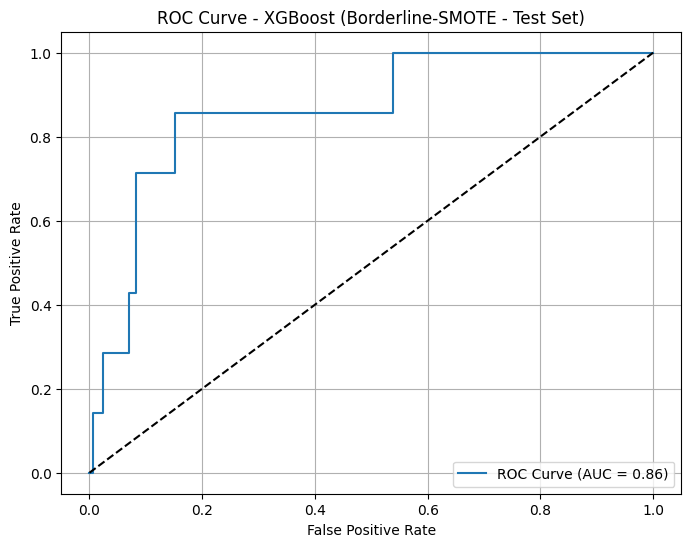

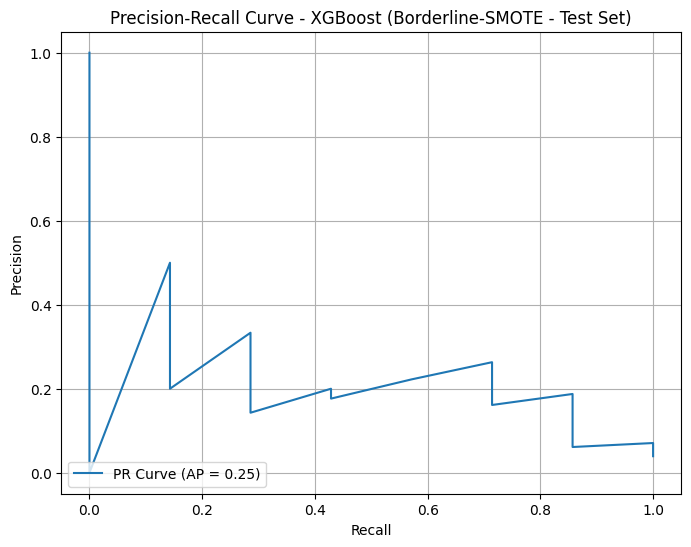

In [ ]:
# ------------------------------------------------------------------------------
# ROC-AUC Curve XGB (Borderline-SMOTE)



fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f'ROC Curve (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost (Borderline-SMOTE - Test Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()




# -------------------------------------------
# Precision-Recall (PR) Curve
precision_xgb_curve, recall_xgb_curve, thresholds_pr_xgb = precision_recall_curve(y_test, y_proba_xgb)
ap_score_xgb = average_precision_score(y_test, y_proba_xgb)

plt.figure(figsize=(8, 6))
plt.plot(recall_xgb_curve, precision_xgb_curve, label=f'PR Curve (AP = {ap_score_xgb:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - XGBoost (Borderline-SMOTE - Test Set)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


# TabNet

In [ ]:
!pip install pytorch-tabnet
!pip install optuna # Hyperparameter tuning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 918.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
# ------------------------------------------------------------------------------
# TabNet with Borderline-SMOTE inside CV and Optuna hyperparameter tuning
# ------------------------------------------------------------------------------



# ------------------------------------------------------

# set full random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


# preprocess data types
X_train_fixed = X_train.copy()
X_test_fixed = X_test.copy()

bool_cols = X_train_fixed.select_dtypes(include='bool').columns
X_train_fixed[bool_cols] = X_train_fixed[bool_cols].astype(int)
X_test_fixed[bool_cols] = X_test_fixed[bool_cols].astype(int)

X_train_fixed = X_train_fixed.astype(np.float32)
X_test_fixed = X_test_fixed.astype(np.float32)

X_np = X_train_fixed.to_numpy()
y_np = y_train.to_numpy()

# ------------------------------------------------------







# Optuna objective with Borderline-SMOTE inside CV
def objective(trial):
    set_seed(42)  # Set seed inside each trial

    params = {
        "n_d": trial.suggest_int("n_d", 8, 64, step=8),
        "n_a": trial.suggest_int("n_a", 8, 64, step=8),
        "n_steps": trial.suggest_int("n_steps", 3, 10),
        "gamma": trial.suggest_float("gamma", 1.0, 2.0),
        "lambda_sparse": trial.suggest_float("lambda_sparse", 1e-5, 1e-1, log=True),
        "optimizer_params": {"lr": trial.suggest_float("lr", 1e-3, 1e-1, log=True)},
        "mask_type": "entmax",
        "scheduler_fn": torch.optim.lr_scheduler.StepLR,
        "scheduler_params": {"step_size": 10, "gamma": 0.9},
        "verbose": 0,
        "seed": 42
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in skf.split(X_np, y_np):
        X_train_fold, y_train_fold = X_np[train_idx], y_np[train_idx]
        X_val_fold, y_val_fold = X_np[val_idx], y_np[val_idx]

        # BorderlineSMOTE only applied to training folds
        X_resampled, y_resampled = BorderlineSMOTE(random_state=42).fit_resample(X_train_fold, y_train_fold)

        model = TabNetClassifier(**params)
        model.fit(
            X_resampled, y_resampled,
            eval_set=[(X_val_fold, y_val_fold)],
            eval_metric=["balanced_accuracy"],
            max_epochs=100,
            patience=10,
            batch_size=256,
            virtual_batch_size=128
        )

        preds = model.predict(X_val_fold)
        scores.append(f1_score(y_val_fold, preds))

    return np.mean(scores)






# Optuna tuning with fixed seed
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=42) # seed
)
study.optimize(objective, n_trials=30, timeout=600)






# retrain on full BorderlineSMOTE-resampled training data with best params
best_params = study.best_params
print("Best TabNet Parameters:", best_params)

X_train_resampled, y_train_resampled = BorderlineSMOTE(random_state=42).fit_resample(X_np, y_np)

final_model = TabNetClassifier(
    n_d=best_params["n_d"],
    n_a=best_params["n_a"],
    n_steps=best_params["n_steps"],
    gamma=best_params["gamma"],
    lambda_sparse=best_params["lambda_sparse"],
    optimizer_params={"lr": best_params["lr"]},
    mask_type="entmax",
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    scheduler_params={"step_size": 10, "gamma": 0.9},
    verbose=0,
    seed=42
)

final_model.fit(
    X_train_resampled, y_train_resampled,
    eval_set=[(X_train_resampled, y_train_resampled)],
    eval_metric=["balanced_accuracy"],
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=128
)







# Evaluate on TRAINING set
y_train_pred = final_model.predict(X_train_resampled)
y_train_proba = final_model.predict_proba(X_train_resampled)[:, 1]

print("\nTraining Performance:")
print(f"Precision: {precision_score(y_train_resampled, y_train_pred):.4f}")
print(f"Recall: {recall_score(y_train_resampled, y_train_pred):.4f}")
print(f"F1 Score: {f1_score(y_train_resampled, y_train_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_train_resampled, y_train_proba):.4f}")
print(f"Cohen’s Kappa: {cohen_kappa_score(y_train_resampled, y_train_pred):.4f}")






# Evaluate on TEST set
X_test_np = X_test_fixed.to_numpy()
y_test_np = y_test.to_numpy()

y_test_pred = final_model.predict(X_test_np)
y_test_proba = final_model.predict_proba(X_test_np)[:, 1]

print("\nTest Performance:")
print(classification_report(y_test_np, y_test_pred))
print(f"Precision: {precision_score(y_test_np, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test_np, y_test_pred):.4f}")
print(f"F1 Score: {f1_score(y_test_np, y_test_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test_np, y_test_proba):.4f}")
print(f"Cohen’s Kappa: {cohen_kappa_score(y_test_np, y_test_pred):.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test_np, y_test_pred))



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.59559


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_balanced_accuracy = 0.6777


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_balanced_accuracy = 0.74632


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_balanced_accuracy = 0.66912


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 38 with best_epoch = 28 and best_val_0_balanced_accuracy = 0.81618


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_balanced_accuracy = 0.74755


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.6875


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_balanced_accuracy = 0.8027


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.61912


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_balanced_accuracy = 0.63456


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_balanced_accuracy = 0.78064


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.70833


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_balanced_accuracy = 0.88235


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_balanced_accuracy = 0.71985


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_balanced_accuracy = 0.68309


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_balanced_accuracy = 0.73897


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_0_balanced_accuracy = 0.75613


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_balanced_accuracy = 0.74387


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 31 with best_epoch = 21 and best_val_0_balanced_accuracy = 0.64191


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.67941


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.74632


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.6875


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_balanced_accuracy = 0.61397


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_balanced_accuracy = 0.60441


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_balanced_accuracy = 0.72279


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.79167


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_balanced_accuracy = 0.66912


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.72917


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.71176


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.675


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.57843


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 52 with best_epoch = 42 and best_val_0_balanced_accuracy = 0.78186


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.71078


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_0_balanced_accuracy = 0.78971


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_0_balanced_accuracy = 0.79779


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_balanced_accuracy = 0.86397


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_balanced_accuracy = 0.70833


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_balanced_accuracy = 0.8027


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.61985


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_balanced_accuracy = 0.76765


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.8174


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_balanced_accuracy = 0.71446


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 31 with best_epoch = 21 and best_val_0_balanced_accuracy = 0.88971


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.65074


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.78309


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_balanced_accuracy = 0.82108


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_balanced_accuracy = 0.70466


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_balanced_accuracy = 0.76593


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.64265


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_balanced_accuracy = 0.69706


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_balanced_accuracy = 0.81005


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_balanced_accuracy = 0.77451


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_balanced_accuracy = 0.83088


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_balanced_accuracy = 0.74926


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_balanced_accuracy = 0.64853


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_balanced_accuracy = 0.83456


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_balanced_accuracy = 0.72304


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_balanced_accuracy = 0.75858


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 36 with best_epoch = 26 and best_val_0_balanced_accuracy = 0.64118


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.81985


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_0_balanced_accuracy = 0.74877


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.72181


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_balanced_accuracy = 0.77696


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_balanced_accuracy = 0.65294


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_balanced_accuracy = 0.80882


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_balanced_accuracy = 0.71569


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_balanced_accuracy = 0.82108


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_balanced_accuracy = 0.88603


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_balanced_accuracy = 0.62647


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_balanced_accuracy = 0.74191


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 36 with best_epoch = 26 and best_val_0_balanced_accuracy = 0.69853


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_balanced_accuracy = 0.70588


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_balanced_accuracy = 0.83211


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_balanced_accuracy = 0.62647


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_balanced_accuracy = 0.71176


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_balanced_accuracy = 0.90074


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_0_balanced_accuracy = 0.75245


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.8174


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.65956


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.85294


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_balanced_accuracy = 0.74142


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 39 with best_epoch = 29 and best_val_0_balanced_accuracy = 0.77819


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_balanced_accuracy = 0.75245


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.71176


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_balanced_accuracy = 0.70441


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.67034


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_balanced_accuracy = 0.67157


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.69975


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.63456


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_balanced_accuracy = 0.82279


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_balanced_accuracy = 0.80637


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_balanced_accuracy = 0.66789


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_balanced_accuracy = 0.70588


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_balanced_accuracy = 0.78603


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 32 with best_epoch = 22 and best_val_0_balanced_accuracy = 0.67794


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Best TabNet Parameters: {'n_d': 64, 'n_a': 32, 'n_steps': 6, 'gamma': 1.064754632751776, 'lambda_sparse': 0.012590010898254945, 'lr': 0.03424933882463793}

Early stopping occurred at epoch 71 with best_epoch = 61 and best_val_0_balanced_accuracy = 1.0


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Training Performance:
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000
Cohen’s Kappa: 1.0000

Test Performance:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       171
           1       0.14      0.14      0.14         7

    accuracy                           0.93       178
   macro avg       0.55      0.55      0.55       178
weighted avg       0.93      0.93      0.93       178

Precision: 0.1429
Recall: 0.1429
F1 Score: 0.1429
ROC AUC: 0.6140
Cohen’s Kappa: 0.1078

Confusion Matrix:
 [[165   6]
 [  6   1]]


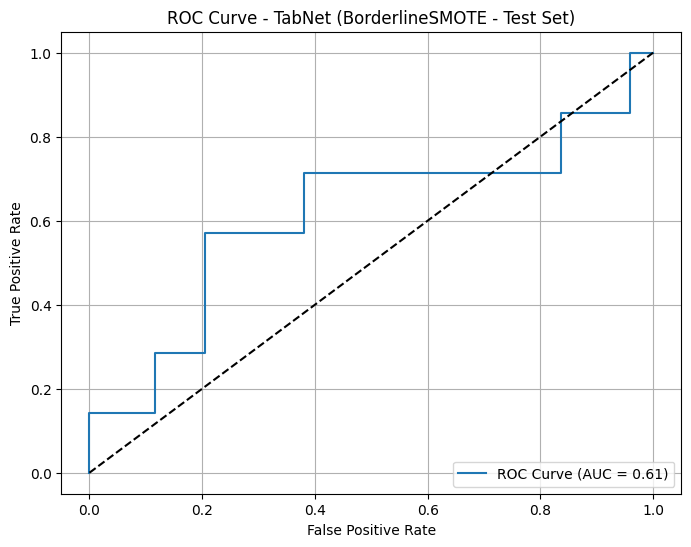

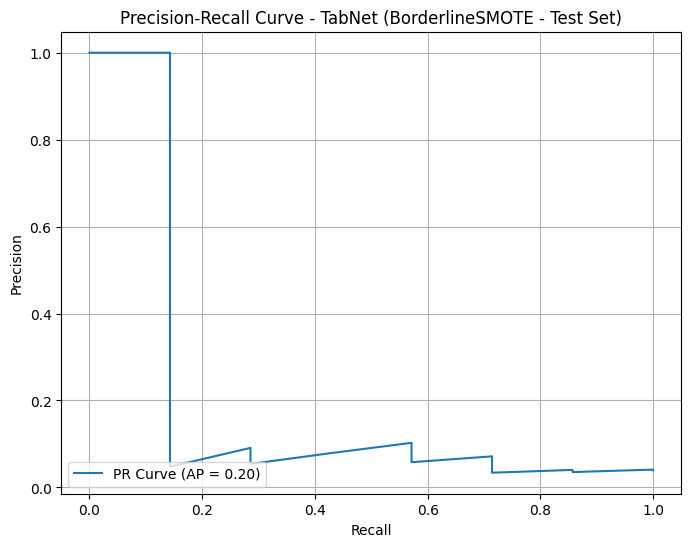

In [ ]:
# ------------------------------------------------------------------------------
# ROC-AUC and PR Curve TabNet (Borderline-SMOTE)




fpr, tpr, _ = roc_curve(y_test_np, y_test_proba)
roc_auc = roc_auc_score(y_test_np, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - TabNet (BorderlineSMOTE - Test Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()





# ------------------------------------------------------
# Precision-Recall (PR) Curve


precision, recall, _ = precision_recall_curve(y_test_np, y_test_proba)
ap_score = average_precision_score(y_test_np, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - TabNet (BorderlineSMOTE - Test Set)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
